In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import math
from torch.utils.data import DataLoader, Dataset
import torch
import matplotlib.pyplot as plt

from _basicClasses import TimeSeriesDatasetSingleSubject, GlobalModel, LocalModel
from _train_pred import predict, evaluate, train, split_dataset

In [2]:
K = 5  # Number of final factors 
# Parameters for the dataset
# J = 5 # Number of subjects
D = 5   # Number of features
T = 150   # Number of time points
C = 2   # Number of categorical variables
C_levels = 3
num_epochs = 100  # Number of epochs for training
hidden_size_global = 100 
hidden_size_local = 5
train_ratio=.8
batch_size = 32

In [3]:
# time[:6]

In [4]:

torch.manual_seed(19)

# Generate time-dependent patient features
time = torch.arange(1, T+1).float() / 50  # Normalize time for smoother variations
X = torch.zeros(T, D)

# time-dependent patterns for features
for d in range(D):
    # Linear trend + sine wave pattern to simulate periodic changes (e.g., seasonal effects)
    X[:, d] = .5 * d * time +  torch.sin(2 * math.pi * time / max(10, d + 1)) + torch.randn(T) * 0.1

# Categorical Variables
gender = torch.randint(0, 3, (T, 1))  # Three categories for gender
country = torch.randint(0, 3, (T, 1))  # Three countries
cat_vars = torch.cat([gender, country], dim=1)

# # Adjusting Y for categorical variables and time
base_bp_gender = torch.tensor([0.0, 5.0, 3.0]).float()

binary_event = (1/(1 + torch.exp( -(1*X[:,0] + .5* X[:,2] -1* X[:,3]) -   .6* base_bp_gender[gender].squeeze() )) > .9).int()
# binary_event = (abs(X[:, 2] + X[:, 3] + X[:, 0]) > 3.5).int()
weights_X = torch.randn(D) * .1
# Y = torch.matmul(X, weights_X)* 10  + torch.randn(T)*.1 + .1 * base_bp_gender[gender].squeeze()

# X -= X.mean(dim=0)
# X /= X.std(dim=0)

Y  = X[:, 0]


# Binary event based on a threshold
threshold = 0
# binary_event = (abs(Y) > threshold).int()

# Assuming TimeSeriesDatasetSingleSubject is defined appropriately elsewhere
dataset = TimeSeriesDatasetSingleSubject(X, Y, cat_vars, binary_event, input_window_size=24, output_window_size=24)
print(binary_event[-30:])

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=torch.int32)


In [5]:
print(binary_event.shape)
print(cat_vars.shape)
print(Y.shape)

torch.Size([150])
torch.Size([150, 2])
torch.Size([150])


In [6]:
print(5*torch.sin(2 * math.pi * time / max(10, d + 1))[:5])
print(torch.randn(T)[:5]/10)
print( 1* d * time[:5] )

tensor([0.0628, 0.1257, 0.1885, 0.2512, 0.3140])
tensor([-0.0236,  0.0333,  0.1224,  0.1186,  0.1162])
tensor([0.0800, 0.1600, 0.2400, 0.3200, 0.4000])


In [7]:
# Y.shape
print(torch.matmul(X, weights_X)[:5]*10)
torch.randn(T)[:5]*.1

tensor([-0.5943, -0.3270, -0.2568, -0.3343, -0.6839])


tensor([-0.2475,  0.1200,  0.0568, -0.1731, -0.0173])

In [8]:

train_dataset, test_dataset = split_dataset(dataset, r=0.4)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [9]:
# Assuming the model instances are created like this:
global_model = GlobalModel(D, hidden_size_global, K, output_window_size= 24)

# 1 + num_categorical_features: 
local_model = LocalModel(1 + C, hidden_size_local, output_window_size= 24)

# event_model = EventModel(C, hidden_dim= 10)
# event_model = EventModel(1 + C, hidden_size_local)

optimizer = torch.optim.Adam(list(global_model.parameters()) + list(local_model.parameters()), lr=0.005)


In [10]:

# For early stopping
patience = 10
min_loss = float('inf')
best_model = None
best_epoch = 0

for epoch in range(num_epochs):
    train_loss = train(global_model, local_model, optimizer, train_dataloader)
    test_loss = evaluate(global_model, local_model, test_dataloader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch 1, Train Loss: 3.9144, Test Loss: 2.0254
Epoch 2, Train Loss: 2.0230, Test Loss: 2.4730
Epoch 3, Train Loss: 1.5267, Test Loss: 2.6276
Epoch 4, Train Loss: 1.3344, Test Loss: 2.4152
Epoch 5, Train Loss: 1.4067, Test Loss: 2.4984
Epoch 6, Train Loss: 1.3807, Test Loss: 2.8599
Epoch 7, Train Loss: 1.2931, Test Loss: 3.2815
Epoch 8, Train Loss: 1.2942, Test Loss: 3.0763
Epoch 9, Train Loss: 1.2728, Test Loss: 2.5790
Epoch 10, Train Loss: 1.2567, Test Loss: 2.2851
Epoch 11, Train Loss: 1.2644, Test Loss: 2.2658
Epoch 12, Train Loss: 1.2521, Test Loss: 2.4641
Epoch 13, Train Loss: 1.2256, Test Loss: 2.7664
Epoch 14, Train Loss: 1.2135, Test Loss: 2.9373
Epoch 15, Train Loss: 1.2064, Test Loss: 2.8480
Epoch 16, Train Loss: 1.1884, Test Loss: 2.6335
Epoch 17, Train Loss: 1.1758, Test Loss: 2.4706
Epoch 18, Train Loss: 1.1673, Test Loss: 2.4284
Epoch 19, Train Loss: 1.1513, Test Loss: 2.4895
Epoch 20, Train Loss: 1.1358, Test Loss: 2.5555
Epoch 21, Train Loss: 1.1252, Test Loss: 2.5157
E

In [11]:
W = (global_model).get_weight_matrix()
print(W)

Parameter containing:
tensor([ 0.2964,  2.7388,  1.2939,  0.6266, -0.0139], requires_grad=True)


In [12]:
A = global_model.get_weight_matrix()
print(A)

Parameter containing:
tensor([ 0.2964,  2.7388,  1.2939,  0.6266, -0.0139], requires_grad=True)


In [13]:

# Assuming you've already loaded your test DataLoader: test_dataloader
mus, sigmas, p_collected, z_collected, true_values, binary_events  = predict(global_model, local_model, test_dataloader)

# Convert to numpy for easier handling
mus_np = mus.numpy()
sigmas_np = sigmas.numpy()
p_collected = p_collected.numpy()
z_collected = z_collected.numpy()

true_values_np = true_values.numpy()
binary_events_np = binary_events.numpy()



In [14]:
# print(mus.shape, mus)
# print(sigmas.shape, sigmas)
# print(p_collected.shape, p_collected)
# print(true_values)
print(binary_events_np[-1])
print(p_collected[-1])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.28858435 0.29106358 0.28935114 0.29305574 0.36342752 0.42559567
 0.3709978  0.2875702  0.36711508 0.36490637 0.43239954 0.426197
 0.42848814 0.35586488 0.28869206 0.27876052 0.29138413 0.28518808
 0.2105535  0.14771622 0.14527868 0.1710637  0.09785219 0.11868557]


In [15]:
(mus_np[-1])

array([ 0.48362127,  0.20827687,  1.1220617 ,  1.6578009 ,  1.7339246 ,
        2.0278041 ,  2.5656092 ,  2.4904969 ,  1.6580582 ,  2.1345053 ,
        0.73085845,  1.599163  ,  0.6181587 ,  2.1026785 ,  0.8000604 ,
        1.2514184 ,  0.4018451 ,  0.13811755, -0.5508621 , -0.17220946,
        0.3377968 ,  1.2601154 ,  1.5587052 ,  1.4542625 ], dtype=float32)

In [16]:
true_values_np[-1]

array([0.9902183 , 1.1089245 , 1.0853659 , 1.0146685 , 0.9507285 ,
       0.9686505 , 0.94736904, 0.92133754, 0.81704485, 1.000259  ,
       1.1016221 , 1.0246798 , 1.2400742 , 0.9420569 , 0.95880044,
       1.0018249 , 1.0403636 , 0.9697801 , 1.0362794 , 0.889107  ,
       0.87466097, 1.169436  , 0.92857844, 1.0416622 ], dtype=float32)

In [17]:
(binary_events[-1])


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)

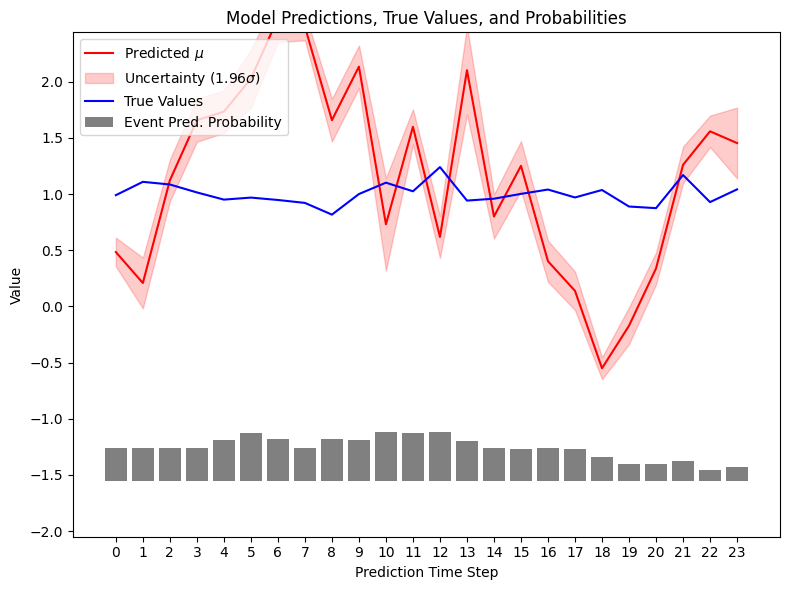

In [18]:
mus_subject = mus_np[-1]
sigmas_subject = sigmas_np[-1]
true_values_subject = true_values_np[-1]
binary_events_subject = binary_events_np[-1]
p_subject = p_collected[-1] # Extracted probabilities


plt.figure(figsize=(8, 6))
plt.plot(mus_subject, label='Predicted $\mu$', color='red')
plt.fill_between(range(len(mus_subject)), (mus_subject - 1.96 * sigmas_subject), (mus_subject + 1.96 * sigmas_subject), color='red', alpha=0.2, label='Uncertainty ($1.96\sigma$)')
plt.plot(true_values_subject, label='True Values', color='blue')

# Plotting the probability as a bar plot at the bottom
bar_height = p_subject  # Scaling factor for visibility
bar_bottom = np.min(mus_subject) -1   # Adjust bottom to avoid overlap
plt.bar(range(len(p_subject)), bar_height,  bottom=bar_bottom, color='gray', label='Event Pred. Probability', width=0.8)

for i, (value, event) in enumerate(zip(true_values_subject, binary_events_subject)):
    if event == 1:
        plt.plot(i, value, 'x', color='black', markersize=8, label='Event = 1' if i == 0 else "")

plt.xticks(range(len(binary_events_subject)))
plt.xlabel('Prediction Time Step')
plt.ylabel('Value')
plt.title('Model Predictions, True Values, and Probabilities')

# plt.axhline(y=threshold, color='gray', linestyle='--', linewidth=1, label='Threshold')
# Adjust y-axis limit to make space for the bar plot
plt.ylim([np.min(bar_bottom)-.5, np.max(true_values_subject) + 1.2])

# Legend
handles, labels = plt.gca().get_legend_handles_labels()
# Ensure unique labels
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

plt.tight_layout()
plt.show()


In [19]:
# mus_subject = mus_np[:,]
# sigmas_subject = sigmas_np[:,0]
# true_values_subject = true_values_np
# binary_events_subject = binary_events_np
# p_subject = p_collected[:,0] # Extracted probabilities


# plt.figure(figsize=(8, 6))
# plt.plot(mus_subject, label='Predicted $\mu$', color='red')
# plt.fill_between(range(len(mus_subject)), (mus_subject - 1.96 * sigmas_subject), (mus_subject + 1.96 * sigmas_subject), color='red', alpha=0.2, label='Uncertainty ($\sigma$)')
# plt.plot(true_values_subject, label='True Values', color='blue')

# # Plotting the probability as a bar plot at the bottom
# bar_height = p_subject* mus_subject.mean()  # Scaling factor for visibility
# bar_bottom = np.min(true_values_subject) -.5   # Adjust bottom to avoid overlap
# plt.bar(range(len(p_subject)), bar_height,  bottom=bar_bottom, color='gray', label='Event Pred. Probability', width=0.8)

# for i, (value, event) in enumerate(zip(true_values_subject, binary_events_subject)):
#     if event == 1:
#         plt.plot(i, value, 'x', color='black', markersize=8, label='Event = 1' if i == 0 else "")

# plt.xticks(range(len(binary_events_subject)))
# plt.xlabel('Prediction Time Step')
# plt.ylabel('Value')
# plt.title('Model Predictions, True Values, and Probabilities')

# # plt.axhline(y=threshold, color='gray', linestyle='--', linewidth=1, label='Threshold')

# # Adjust y-axis limit to make space for the bar plot
# plt.ylim([np.min(bar_bottom)-.5, np.max(true_values_subject) + 1.2])

# # Legend
# handles, labels = plt.gca().get_legend_handles_labels()
# # Ensure unique labels
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys(), loc='upper left')

# plt.tight_layout()
# plt.show()
